# Does Stretching Pulses Amplify Noise? (2)
Testing this on a sample 

In [1]:
from qiskit import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_london')
from qiskit.test.mock import FakeValencia
fake_backend = FakeValencia()

In [2]:
import numpy as np
from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

In [3]:
# set the drive strength
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad1'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad2'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad3'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad4'] = 63455017.85


# set the qubit frequency
freq_est = 4.97e9
fake_backend.defaults().qubit_freq_est = [freq_est]
#getattr(fake_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [4]:
fake_backend.configuration()

PulseBackendConfiguration(acquisition_latency=[], allow_object_storage=True, allow_q_circuit=False, allow_q_object=True, backend_name='fake_valencia', backend_version='1.1.0', basis_gates=['u1', 'u2', 'u3', 'cx', 'id'], conditional=False, conditional_latency=[], coupling_map=[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]], credits_required=True, description='5 qubit device Valencia', discriminators=['linear_discriminator', 'quadratic_discriminator'], dt=2.2222222222222221e-10, dtm=2.2222222222222221e-10, gates=[GateConfig(id, [], gate id q { U(0,0,0) q; }, [[0], [1], [2], [3], [4]]), GateConfig(u1, ['lambda'], gate u1(lambda) q { U(0,0,lambda) q; }, [[0], [1], [2], [3], [4]]), GateConfig(u2, ['phi', 'lambda'], gate u2(phi,lambda) q { U(pi/2,phi,lambda) q; }, [[0], [1], [2], [3], [4]]), GateConfig(u3, ['theta', 'phi', 'lambda'], gate u3(theta,phi,lambda) q { U(theta,phi,lambda) q; }, [[0], [1], [2], [3], [4]]), GateConfig(cx, [], gate cx q1,q2 { CX q1,q2; }, [[0, 1], [1

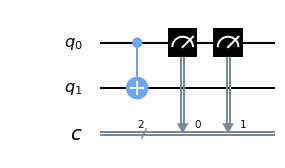

In [5]:
circ = QuantumCircuit(2,2)
circ.cx(0, 1)
circ.measure(0,0)
circ.measure(0,1)
circ.draw(output = 'mpl')

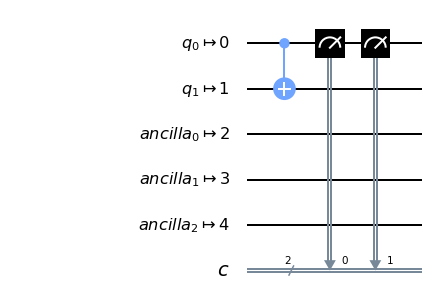

In [6]:




from qiskit.compiler import transpile
circ_device = transpile(circ, fake_backend)
circ_device.draw(output = 'mpl')

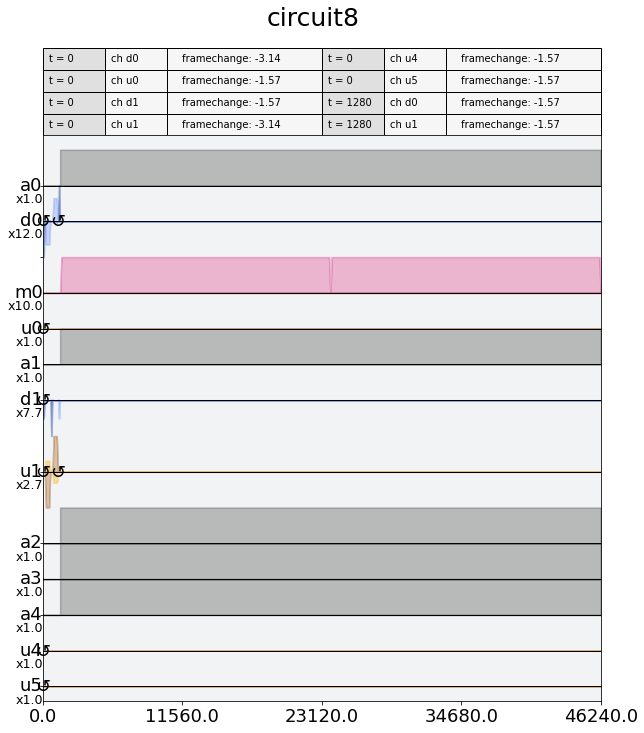

In [7]:
from qiskit.compiler import schedule 
sched_circ = schedule(circ_device, fake_backend)
sched_circ.draw()

In [21]:
sched_circ.instructions[9][1].channels

(ControlChannel(1),)

In [5]:
def stretchSamples(arr):
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/2
        new_arr.append(a)
        new_arr.append(a)
    return new_arr

In [6]:
new_sched = pulse.Schedule(name = "stretching the X gate")
#adding phase shift 
new_sched+=sched_circ.instructions[0][1]


In [7]:
new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(sched_circ.instructions[1][1].pulse.samples)), pulse.DriveChannel(0))

In [8]:
new_sched+= sched_circ.instructions[2][1]

In [9]:
new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(sched_circ.instructions[3][1].pulse.samples)), pulse.DriveChannel(0))

In [10]:
new_sched+= sched_circ.instructions[4][1]

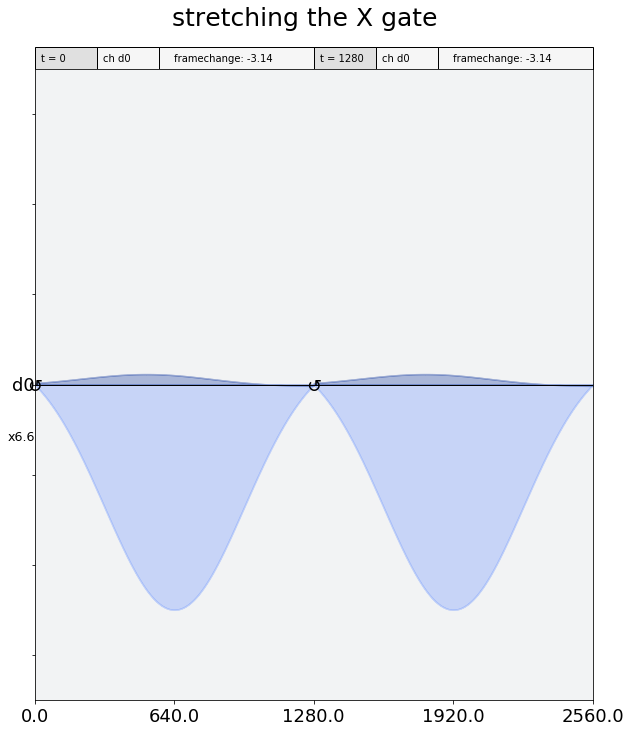

In [72]:
new_sched.draw()

# Stretching X

In [11]:
from qiskit.scheduler import measure
def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the X gate")
    #adding phase shift 
    new_sched+=instruc[0][1]
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=instruc[2][1]
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[3][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=instruc[4][1]
    new_sched +=measure([0], backend) <<new_sched.duration
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))
    

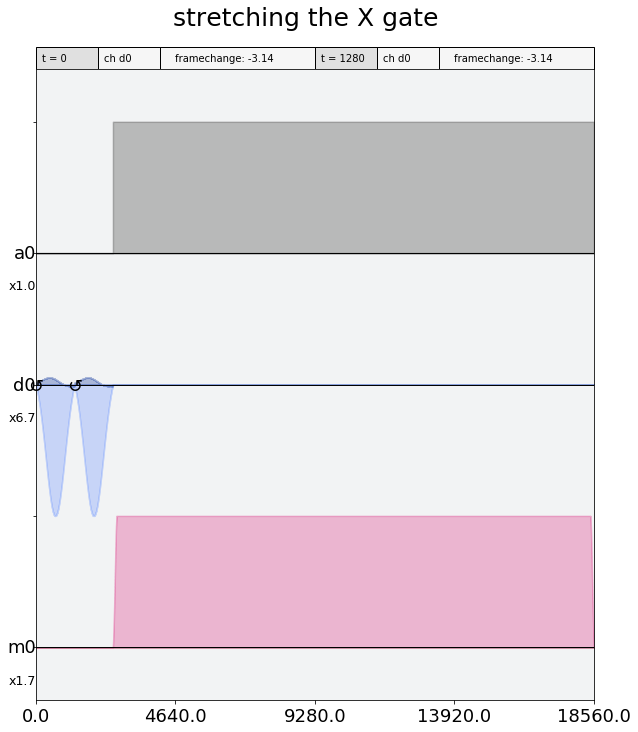

In [12]:
scaled_schedules[1].draw()

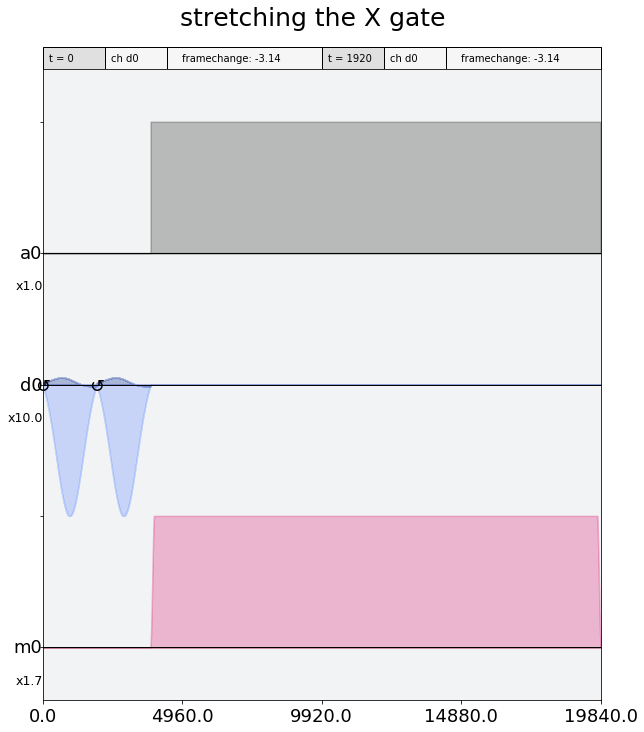

In [13]:
scaled_schedules[2].draw()

In [17]:
job = execute(scaled_schedules, backend, shots = 2048, meas_level=2 )

In [18]:
result = job.result(timeout=120)
scale_factor = 1e-14
def baseline_remove(values):
    return np.array(values) - np.mean(values)


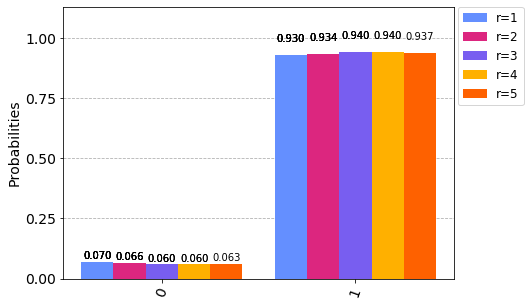

In [19]:
from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

## Applying Measurement Error Mitigation

In [23]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.tools.monitor import job_monitor

qr = qiskit.QuantumRegister(1)

cal_circuits, state_labels = complete_meas_cal(qr=qr, 
                                               circlabel='measurement_calibration')

cal_job = execute(cal_circuits,
             backend=backend,
             shots=8192,
             optimization_level=0)
#print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


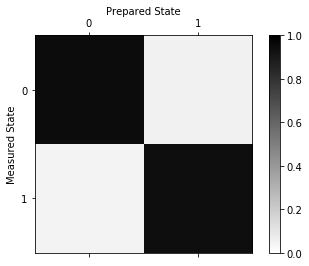

In [24]:

#making a filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter
meas_fitter.plot_calibration()

In [25]:
mitigated_result = meas_filter.apply(result)

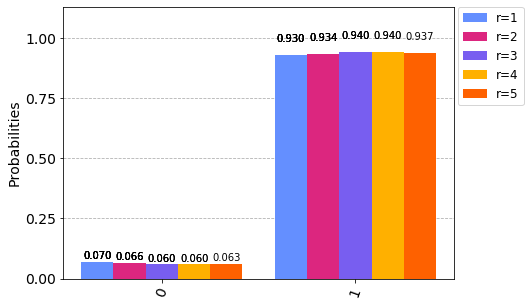

In [26]:
from qiskit.visualization import plot_histogram
mit_results=[]
for i in range(5): 
    mit_results.append(mitigated_result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

# Stretching XX

In [27]:
circ = QuantumCircuit(1,1)

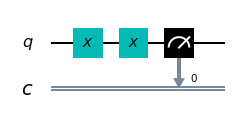

In [28]:
circ.x(0)
circ.x(0)
circ.measure(0,0)
circ.draw(output = 'mpl')

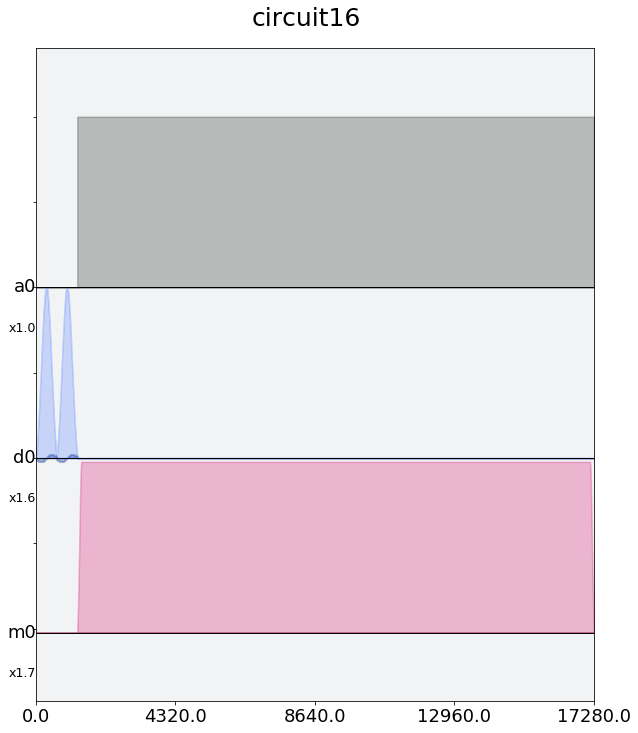

In [29]:
circ_trans = transpile(circ, backend)
sched_circ = schedule(circ, backend)
sched_circ.draw()

In [30]:
sched_circ.timeslots

{DriveChannel(0): [(0, 640), (640, 1280)],
 MeasureChannel(0): [(1280, 17280)],
 AcquireChannel(0): [(1280, 17280)],
 MemorySlot(0): [(1280, 17280)]}

In [31]:
sched_circ.instructions

((0,
  Play(SamplePulse(array([0.00121178-5.99530526e-03j, 0.00243494-6.05147984e-03j,
         0.00366953-6.10788213e-03j, 0.0049156 -6.16450794e-03j,
         0.00617319-6.22135354e-03j, 0.00744234-6.27841521e-03j,
         0.00872311-6.33568875e-03j, 0.01001552-6.39316952e-03j,
         0.01131963-6.45085424e-03j, 0.01263548-6.50873780e-03j,
         0.01396309-6.56681601e-03j, 0.01530252-6.62508467e-03j,
         0.01665381-6.68353913e-03j, 0.01801698-6.74217474e-03j,
         0.01939208-6.80098636e-03j, 0.02077913-6.85996981e-03j,
         0.02217818-6.91911951e-03j, 0.02358926-6.97843125e-03j,
         0.0250124 -7.03789946e-03j, 0.02644763-7.09751947e-03j,
         0.02789499-7.15728523e-03j, 0.02935449-7.21719209e-03j,
         0.03082617-7.27723399e-03j, 0.03231006-7.33740628e-03j,
         0.03380619-7.39770290e-03j, 0.03531456-7.45811826e-03j,
         0.03683522-7.51864677e-03j, 0.03836818-7.57928193e-03j,
         0.03991346-7.64001906e-03j, 0.04147109-7.70085072e-03j,
   

In [32]:
from qiskit.scheduler import measure
def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the XX gate")
    #adding phase shift 
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[0][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched +=measure([0], backend) <<new_sched.duration
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))

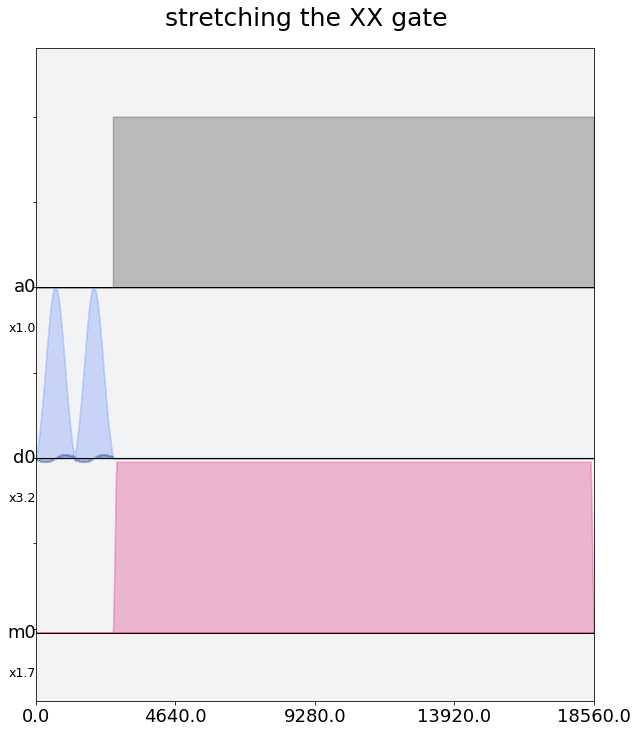

In [33]:
scaled_schedules[1].draw()

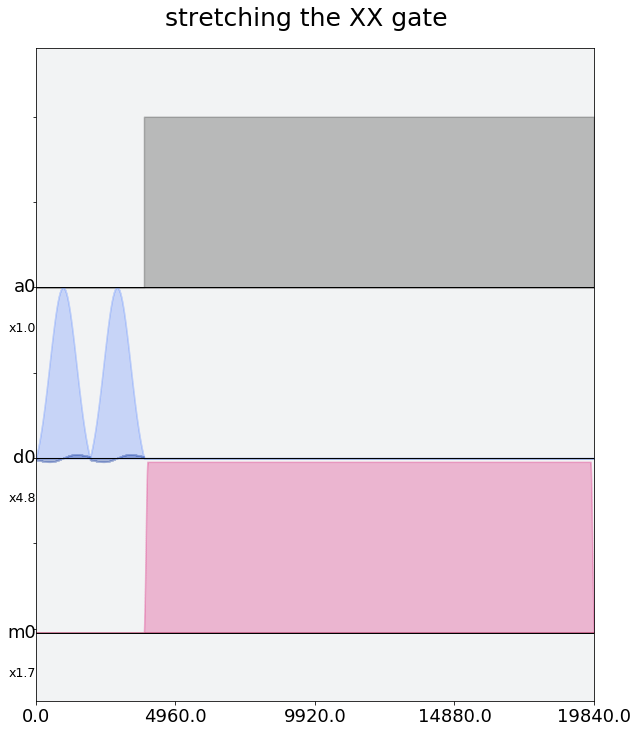

In [34]:
scaled_schedules[2].draw()

In [35]:
job = execute(scaled_schedules, backend, shots = 2048, meas_level=2 )
result = job.result(timeout=120)
scale_factor = 1e-14
def baseline_remove(values):
    return np.array(values) - np.mean(values)


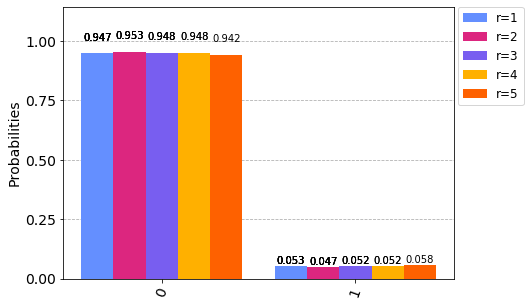

In [36]:
from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

### Applying Measurement Error Mitigation

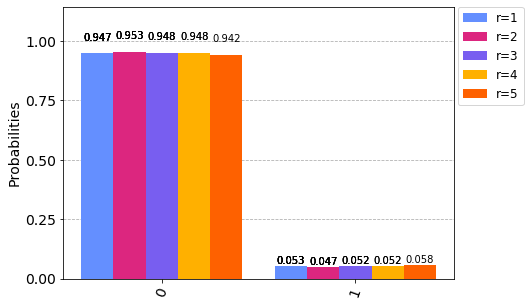

In [37]:
mitigated_result = meas_filter.apply(result)
mit_results=[]
for i in range(5): 
    mit_results.append(result.get_counts(i))
plot_histogram(mit_results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

# Analysis
Stretching one or 2 pauli gates does not really make a difference, if they are the only gates in the circuit. Need to make larger circuits and stretch the single qubit gates in them

# Stretching Arbitrary number of XX's

In [39]:
# Stretching gates with factors 

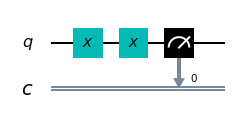

In [40]:
circ.draw(output='mpl')

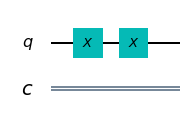

In [41]:
circ = QuantumCircuit(1,1)
circ.x(0)
circ.x(0)
circ.draw(output='mpl')

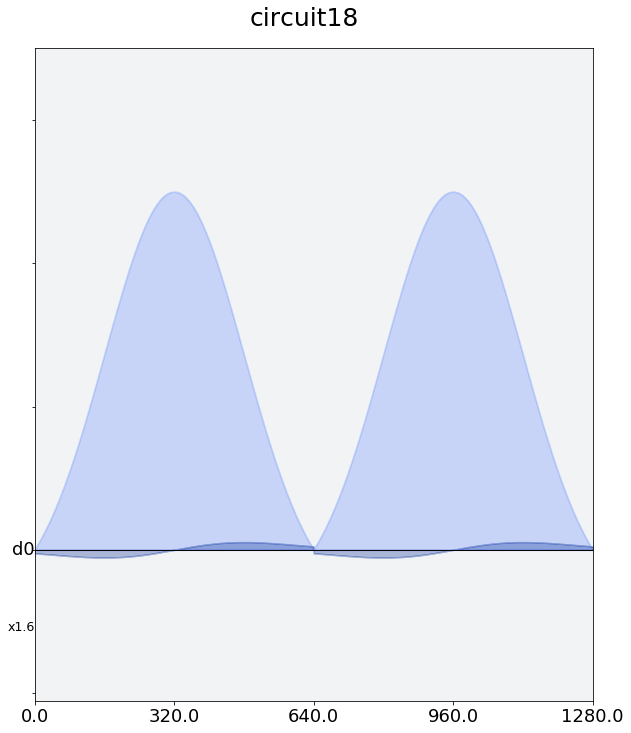

In [42]:
circ_trans = transpile(circ, backend)
sched_circ = schedule(circ, backend)
sched_circ.draw()

In [43]:
sched_one = sched_circ.append(sched_circ)

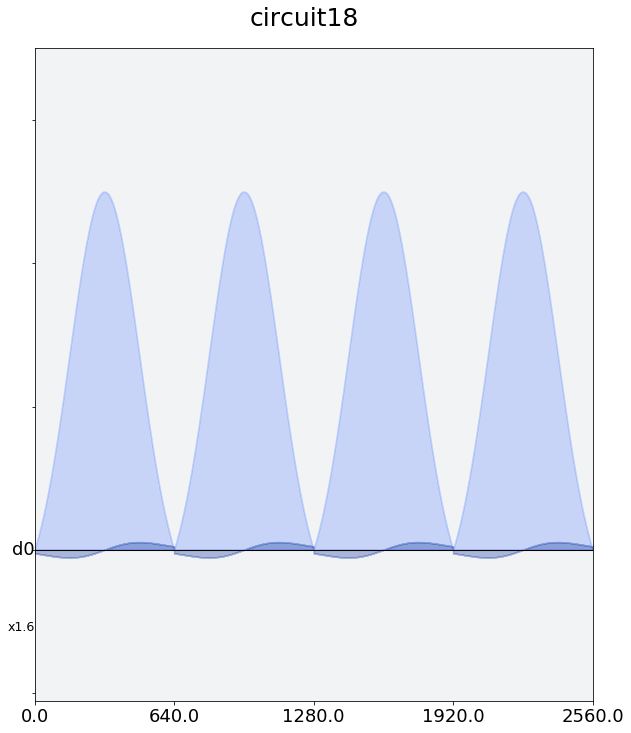

In [44]:
sched_one.draw()

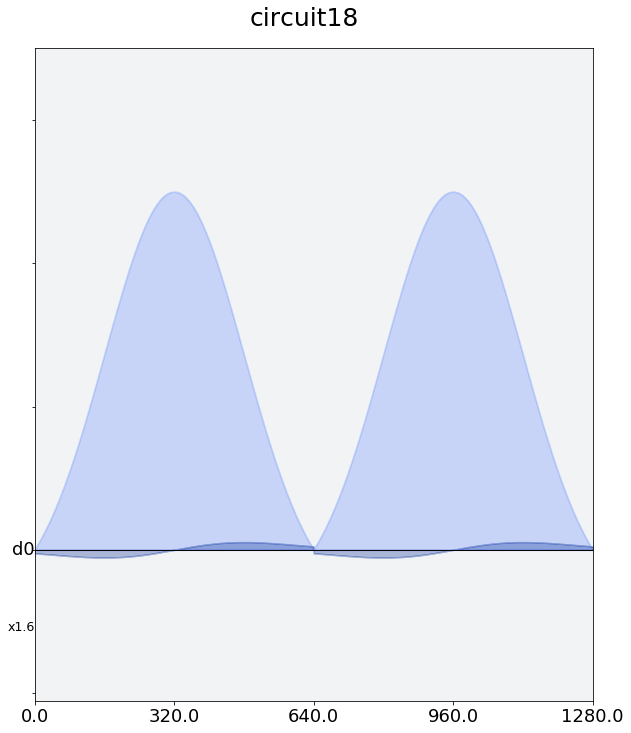

In [45]:
sched_circ.draw()

In [46]:
scaled_circ = []

def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the XX gate")
    #adding phase shift 
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[0][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))

In [47]:
#varying gates and schedules 
circ_gates = []

for circus in scaled_schedules:
    #varying XXs
    #1
    circy = circus
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circus)
    
    #10
    circy = circus
    for i in range(4): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #20
    circy = circus
    for i in range(9): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #50
    circy = circus
    for i in range(24): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #80
    circy = circus
    for i in range(39): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #100
    circy = circus
    for i in range(49): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #200
    circy = circus
    for i in range(99): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)


    

In [48]:
len(circ_gates)

35

In [49]:
job = execute(circ_gates, backend, shots = 8192, meas_level=2 )
job_monitor(job)



Job Status: job has successfully run


In [50]:
results = job.result(timeout = 120)

In [53]:
def get_prob(counts, k): 
    probs = []
    for i in range(7): 
        probs = probs + [((counts[k+i]['0'])/8192)]
    return probs
        


counts =[]
for i in range(35): 
    counts.append(results.get_counts(i))
scalings =[]
for i in range(5): 
    scalings.append([])
for i in range(5): 
    k = 7*i
    scalings[i] = get_prob(counts, k)


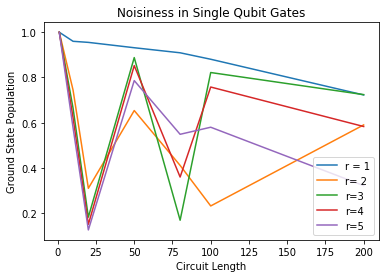

In [55]:
import matplotlib.pyplot as plt
num_gates = [1, 10, 20, 50 ,80,  100, 200]
distances=num_gates
plt.plot(distances, scalings[0], label="r = 1")
plt.plot(distances, scalings[1], label="r= 2")
plt.plot(distances, scalings[2], label="r=3")
plt.plot(distances, scalings[3], label="r=4")
plt.plot(distances, scalings[4], label="r=5")

plt.xlabel('Circuit Length')
plt.ylabel('Ground State Population')
plt.title('Noisiness in Single Qubit Gates')
plt.legend()
plt.show()

## Performing Linear Extrapolation using Curve Fitting

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


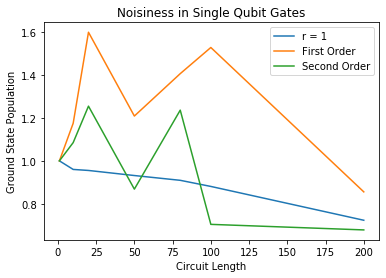

In [58]:
import numpy as np
from scipy.optimize import curve_fit
# extrapolating to 4 orders the entire thing through curve fitting 
orders = []
plot = []
for i in range(2,6): 
    #building up orders through curve fitting 
    some_order = []
    for k in range(len(num_gates)):
        plot=[]
        x = np.array([])
        y = np.array([])
        for c in range(i):
            x = np.append(x, c+1)
            y = np.append(y, scalings[c][k])
        plot.append(x)
        plot.append(y)
        def fit_func(x, a, b):
            return a*x + b
        params = curve_fit(fit_func, x, y)
        [a, b] = params[0]
        plot.append([a, b])
        some_order.append(params[0][1])
    orders.append(some_order)
#plotting the order curves 
num_gates = [1, 10, 20, 50 ,80,  100, 200]
distances=num_gates
plt.plot(distances, scalings[0], label="r = 1")
plt.plot(distances, orders[0], label="First Order")
plt.plot(distances, orders[1], label="Second Order")
#plt.plot(distances, scalings[3], label="r=4")
#plt.plot(distances, scalings[4], label="r=5")   

plt.xlabel('Circuit Length')
plt.ylabel('Ground State Population')
plt.title('Noisiness in Single Qubit Gates')
plt.legend()
plt.show()

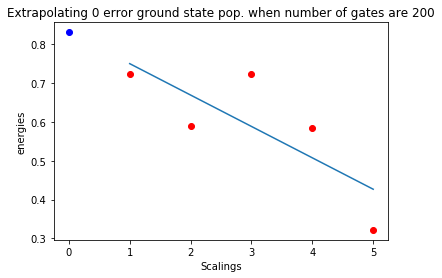

In [61]:
plt.plot(plot[0], plot[1], 'ro')
plt.plot(0, orders[3][6], 'bo')
plt.plot(x, plot[2][0]*x + plot[2][1])
plt.xlabel('Scalings')
plt.ylabel('energies')
plt.title('Extrapolating 0 error ground state pop. when number of gates are 200')
plt.show()